In [11]:
import cv2
import numpy as np
from pathlib import Path
import glob


In [17]:
def align_cardboard(img, target_size):
    """
    Perform perspective correction on the input cardboard image and ensure the long edge is vertical.
    target_size: (width, height)
    """
    # 1. gray + blurred + Canny edges
    gray    = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    edges   = cv2.Canny(blurred, 50, 150)

    # 2. find the largest contour
    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    c = max(cnts, key=cv2.contourArea)

    # 3. Minimum bounding rectangle
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect).astype(int)

    # 4.Sort corners: top left, top right, bottom right, bottom left
    def order_pts(pts):
        pts = pts[np.argsort(pts[:,1])]
        top = pts[:2]; bot = pts[2:]
        top = top[np.argsort(top[:,0])]
        bot = bot[np.argsort(bot[:,0])[::-1]]
        return np.vstack((top, bot))

    src = order_pts(box.astype("float32"))

    # 5. Perspective transformation to target size
    w, h = target_size
    dst = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype="float32")
    M   = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, target_size)

    # 6. If width > height, rotate 90° clockwise.
    if warped.shape[0] < warped.shape[1]:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)

    return warped


In [18]:
def detect_defect(img_ok, img_test, thresh_val=30, diff_thresh=0.01):
    diff = cv2.absdiff(img_ok, img_test)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)

    error_rate = np.count_nonzero(bw) / bw.size
    status = "NQualified" if error_rate > diff_thresh else "Qualified"

    heat    = cv2.applyColorMap(bw, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_test, 0.7, heat, 0.3, 0)

    label = f"Diff: {error_rate:.3f} {status}"
    color = (0,255,0) if status=="Qualified" else (0,0,255)
    cv2.putText(overlay, label, (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

    return overlay, error_rate, status


In [19]:
def batch_template_check(ok_folder, ng_folder, out_folder,
                         thresh_val=30, diff_thresh=0.01):
    ok_folder = Path(ok_folder)
    ng_folder = Path(ng_folder)
    out_folder = Path(out_folder)
    out_folder.mkdir(parents=True, exist_ok=True)

    ok_paths = list(ok_folder.glob("*.png")) + list(ok_folder.glob("*.jpg"))
    if not ok_paths:
        raise FileNotFoundError(f"No template in {ok_folder}")
    ok_raw = cv2.imread(str(ok_paths[0]))
    h, w = ok_raw.shape[:2]; target = (w, h)

    ok_aligned = align_cardboard(ok_raw, target)
    if ok_aligned is None:
        raise RuntimeError("Template alignment failed")

    results = []
    for ext in ("*.png","*.jpg","*.jpeg"):
        for fp in sorted(ng_folder.glob(ext)):
            img_raw = cv2.imread(str(fp))
            if img_raw is None:
                results.append((fp.name, None, "Read failed")); continue
            aligned = align_cardboard(img_raw, target)
            if aligned is None:
                results.append((fp.name, None, "Alignment failed")); continue
            overlay, rate, status = detect_defect(ok_aligned, aligned,
                                 thresh_val, diff_thresh)
            save_path = out_folder / f"vis_{fp.stem}.png"
            cv2.imwrite(str(save_path), overlay)
            results.append((fp.name, rate, status))
    return results


In [20]:
OK_IMG_DIR = "/content/sample_data/images/OK"
NG_DIR     = "/content/sample_data/images/NG"
OUT_DIR    = "/content/sample_data/images/results"

results = batch_template_check(OK_IMG_DIR, NG_DIR, OUT_DIR,
                               thresh_val=30, diff_thresh=0.01)
for name, rate, stat in results:
    rate_str = "--" if rate is None else f"{rate:.3f}"
    print(f"{name:<15}  rate: {rate_str}  {stat}")


10.png           rate: 0.736  NQualified
11.png           rate: 0.711  NQualified
12.png           rate: 0.609  NQualified
14.png           rate: 0.705  NQualified
2.png            rate: 0.598  NQualified
3.png            rate: 0.634  NQualified
4.png            rate: 0.525  NQualified
5.png            rate: 0.699  NQualified
6.png            rate: 0.746  NQualified


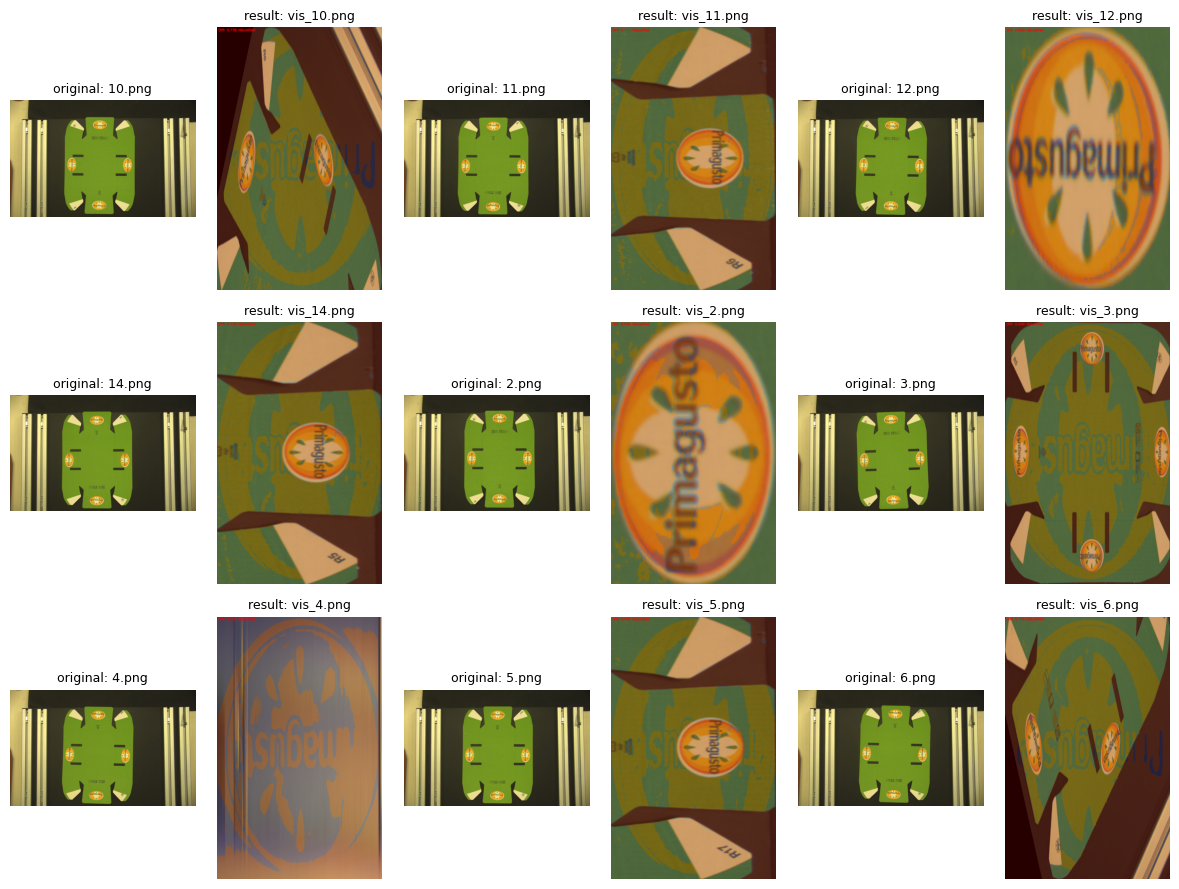

In [23]:
import math
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

NG_DIR   = "/content/sample_data/images/NG"
OUT_DIR  = "/content/sample_data/images/results"

# get the name of every pic
ng_paths  = sorted(Path(NG_DIR).glob("*.*"))
# Only retain the file stem, ensuring that the suffix matches consistently
stems     = [p.stem for p in ng_paths]

# every row to display 3 results
pairs_per_row = 3
n_pairs       = len(stems)
n_rows        = math.ceil(n_pairs / pairs_per_row)

fig, axes = plt.subplots(
    n_rows, pairs_per_row*2,
    figsize=(pairs_per_row*4, n_rows*3),
    squeeze=False
)

for idx, stem in enumerate(stems):
    row = idx // pairs_per_row
    col = idx % pairs_per_row

    # path of original pics
    orig_path = next(Path(NG_DIR).glob(f"{stem}.*"))
    img_orig  = cv2.imread(str(orig_path))
    img_orig  = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # path of results pics
    vis_path  = Path(OUT_DIR) / f"vis_{stem}.png"
    img_vis   = cv2.imread(str(vis_path))
    img_vis   = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)

    # original pic subplot
    ax_orig = axes[row][col*2]
    ax_orig.imshow(img_orig)
    ax_orig.set_title(f"original: {orig_path.name}", fontsize=9)
    ax_orig.axis("off")

    # results pic subplot
    ax_vis = axes[row][col*2 + 1]
    ax_vis.imshow(img_vis)
    ax_vis.set_title(f"result: {vis_path.name}", fontsize=9)
    ax_vis.axis("off")

# Hide extra subplots
total_subplots = n_rows * pairs_per_row * 2
for empty_idx in range(n_pairs*2, total_subplots):
    r = empty_idx // (pairs_per_row*2)
    c = empty_idx % (pairs_per_row*2)
    axes[r][c].axis("off")

plt.tight_layout(w_pad=1.0, h_pad=1.0)
plt.show()

